# Mathematical Underpinnings - Lab 7

In [110]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [111]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return ((mu2-mu1).T @ np.linalg.inv(Sigma2) @ (mu2-mu1) 
            + np.trace(np.linalg.inv(Sigma2)@Sigma1) 
            - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2))
            - mu1.shape[0]
            ) / 2

In [112]:
from scipy.stats import multivariate_normal
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    return np.log(multivariate_normal.pdf(x, mu1, Sigma1) / multivariate_normal.pdf(x, mu2, Sigma2))

### b)

In [113]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)
n = 10000
mu1 = np.array([1, 1, 1, 0, 0])/5
mu2 = np.array([0, 0, 1, 1, 1])/5
Sigma1 = (np.eye(5)*9 + np.ones((5,5)))/10
Sigma2 = 1.2*np.eye(5) - np.ones((5,5))/5
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)))

In [114]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t*y)/n1 - np.log(np.sum(np.exp(t)*(1-y))/n2)

In [115]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [116]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.2030535907414186

### c)

In [117]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term)

### d)

In [118]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [119]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)


In [120]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0391 - val_loss: 0.0119
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: -0.0193
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0175 - val_loss: -0.0399
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0322 - val_loss: -0.0538
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0471 - val_loss: -0.0628
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0509 - val_loss: -0.0696
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0566 - val_loss: -0.0744
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0528 - val_loss: -0.0783
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0573 - val_loss: -0.0814
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0651 - val_loss: -0.0839
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0677 - val_loss: -0.0862
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 

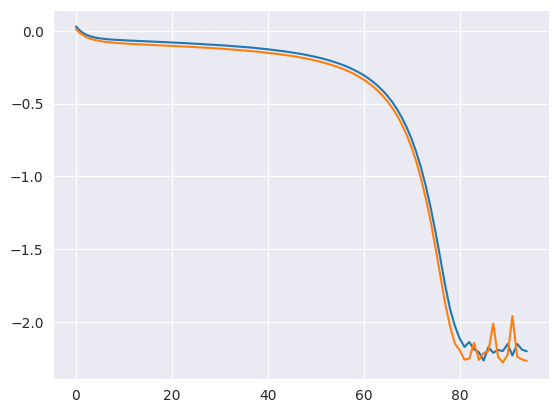

In [121]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [122]:
t_x_pred = model.predict(x)[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


In [123]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

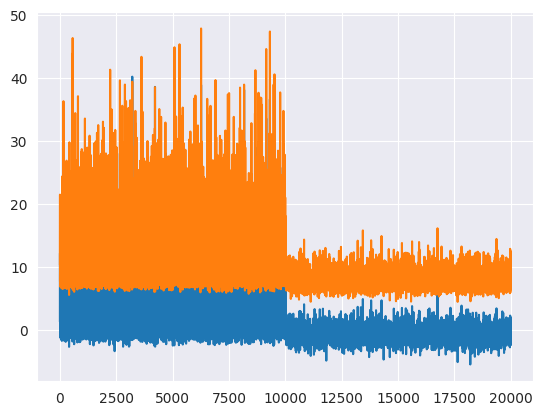

In [124]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

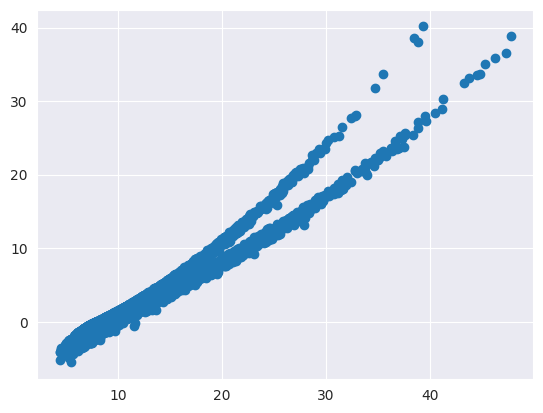

In [125]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [126]:
DV_fun(y, t_x_pred)

2.164906670649179

In [127]:
DV_fun(y, t_x_opt)

2.2030535907414186

In [128]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0*np.ones(n_new), 0.0*np.zeros(n_new)))
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:,0]
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)
DV_fun(y_new, t_x_pred)


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


1.2497882119320565

In [129]:
DV_fun(y_new, t_x_opt)


2.2681119377730177

### f)

In [130]:
def NWJ_loss(y_true, y_pred):
    return -(
            tf.math.reduce_mean(y_pred[y_true==1]) 
            - tf.math.reduce_mean(tf.math.exp(y_pred[y_true==0]-1))
            )

In [131]:
def NWJ_func(y, t):
    return np.mean(t[y==1]) - np.mean(np.exp(t[y==0]-1))

In [132]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])






Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: -0.0512 - val_loss: -0.0793
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0727 - val_loss: -0.0924
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0832 - val_loss: -0.1008
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.0971 - val_loss: -0.1072
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1028 - val_loss: -0.1117
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1109 - val_loss: -0.1169
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1089 - val_loss: -0.1217
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1117 - val_loss: -0.1266
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1205 - val_loss: -0.1320
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1258 - val_loss: -0.1354
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -0.1306 - val_loss: -0.1432
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0

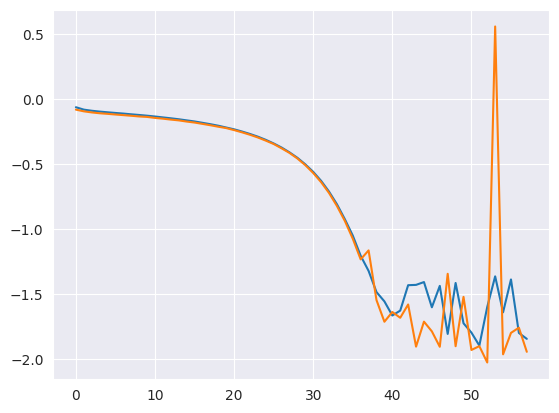

In [133]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step


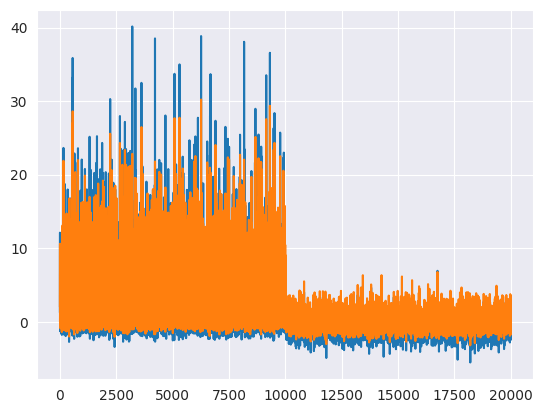

In [134]:

t_x_pred = model.predict(x)[:, 0]
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)
plt.plot(t_x_opt)
plt.plot(t_x_pred)
plt.show()

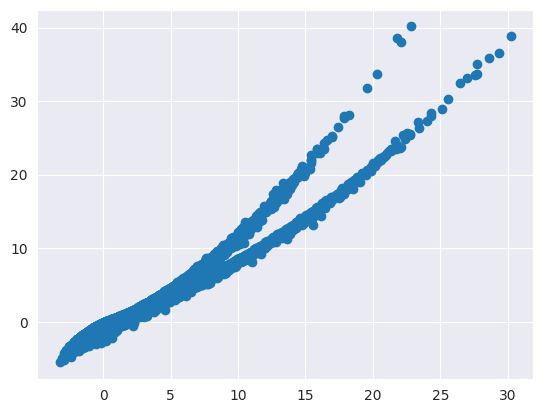

In [135]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [136]:
NWJ_func(y, t_x_pred)


2.0310135

In [137]:
NWJ_func(y, t_x_opt)


1.814356778625707

In [138]:
# new data
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n_new)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n_new)
x_new = np.concatenate((x1, x2), axis=0)
y_new = np.concatenate((1.0 * np.ones(n_new), 0.0 * np.zeros(n_new)))
t_x_pred = model.predict(x_new)
t_x_pred = t_x_pred[:, 0]
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)
NWJ_func(y_new, t_x_pred)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


2.0073457

In [139]:
NWJ_func(y_new, t_x_opt)


1.8514753098900143